In [59]:
from scipy.interpolate import interp1d
import astropy.io.fits as fits
import numpy as np
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import halomod as hm
import hmf
import treecorr
import DarkVerse as dv



In [60]:
%matplotlib inline
plt.rc('font',**{'family':'serif','size':20})
#plt.rc('text', usetex=True)
home_dir = os.path.expanduser('~')
directory_SN_X3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-X3"
directory_SN_C3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-C3"
directory_SN_E2 = "/home/astro/manasoi7/Master_Thesis/Results/SN-E2" 
directory_COSMOS = "/home/astro/manasoi7/Master_Thesis/Results/COSMOS" 
res = os.path.join(home_dir, 'Master_Thesis', 'Results')

In [61]:


home_dir = os.path.expanduser('~')
data_sbi_path = os.path.join(home_dir, 'Master_Thesis', 'DATA', 'DES_DF_SBI')
data_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')


sbi_file_path = os.path.join(data_sbi_path, "DES_DF_COSMOS_sbi_output.fits")  
t= Table.read(sbi_file_path)
t2 = Table.read(os.path.join(data_path, "COSMOS_masked_cat.fits") )
t = join(t,t2,keys='id')

t.rename_column('mode_z','z')
t.rename_column('mode_mass','SM')

# Load Randoms
fits_random = os.path.join(data_path, "COSMOS_randoms_ugriz_trim_video.fits") 
t3 = Table.read(fits_random)
randoms = t3  # Random catalog

# Define Correlation Function Configuration
config = {
    'min_sep': 0.003, 
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'   # if using the internal 'var_method': 'bootstrap' of treecrorr, but then it takes a long time to run
}



In [62]:

z_min, z_max = 0.2, 0.4
SM_min, SM_max = 9,10




In [63]:
z_edges = np.arange(0,5.505,0.005)
# for the n(z), we will use the mid-point of each bin,
z_mid = (z_edges[:-1] + z_edges[1:])/2.
# Let's pick a sample
#subsample = np.where((t['mode_z']>=z_min)&(t['mode_z']<z_max)&(t['mode_mass']>=SM_min)&(t['mode_mass']<SM_max))[0]
subsample = np.where((t['z']>=z_min)&(t['z']<z_max)&(t['SM']>=SM_min)&(t['SM']<SM_max))[0]

# we build the n(z) from the z_pdf column
nz_arr = np.average(t['z_pdf'][subsample,:], axis=0)

# using the average should ensure that the output n(z) is correctly normalised, but we can make sure
nz_arr = nz_arr / np.trapz(nz_arr, x=z_mid)

In [64]:
from scipy.interpolate import interp1d
# we don't want it to crash if we try to access a value outside of our redshift range, instead we'll set such values to 0.
nz = interp1d(z_mid, nz_arr, bounds_error=False, fill_value=0)

# so now we can give it any value that halomod might like to use when performing its integration,
print(nz(0.52752))

0.15063443952798866


In [65]:


# Use it in the Selection class
subsample = dv.Selection(t, randoms, z_min, z_max, SM_min, SM_max, config, nz=nz)

/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/integrate_corr.py:567: UserWarning: Filter function p(x) did not integrate to 1 (0.8264728184845547). Tentatively re-normalising.
  p1 = _check_p(p1, z if p_of_z else x)
/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/integrate_corr.py:572: UserWarning: Filter function p(x) did not integrate to 1 (0.8264728184845547). Tentatively re-normalising.
  p2 = _check_p(p2, z if p_of_z else x)


In [66]:

# Fit HOD with custom bounds
hod_params, pcov = subsample.fit_hod()  

results = subsample.get_results()

logM_min, logM_1, alpha = results['hod_params']
print(f"HOD fit results: M_min = 10^{logM_min*1e7:.2f}, "
      f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")

HOD fit results: M_min = 10^11.05, M_1 = 10^12.55, alpha = 1.02


<>:28: SyntaxWarning: invalid escape sequence '\i'
<>:28: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_322321/2073451028.py:28: SyntaxWarning: invalid escape sequence '\i'
  plt.title(f'$w(\\theta)$ with better n(z) for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [{z_min},{z_max}]$', fontsize=14)


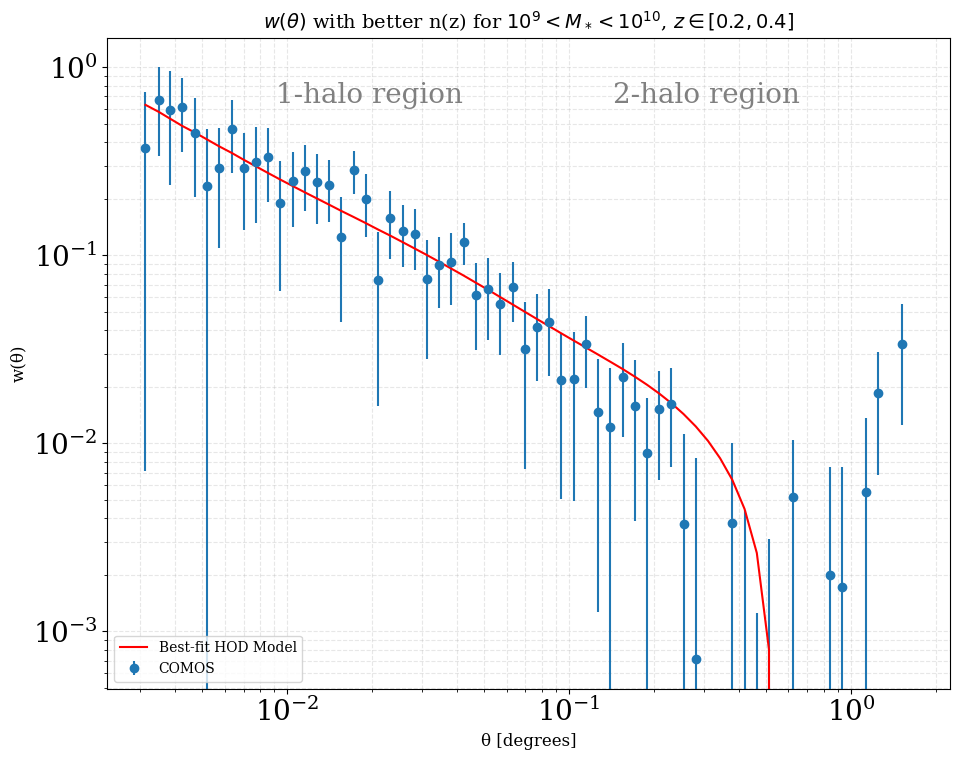

In [67]:
theta = results['theta']
w_obs = results['w_theta']
var_w_obs= results['var_w_theta_bootstrap']
w_err = np.sqrt(var_w_obs)
xi_m_values = results['xi_m']
xi_g_values = results['xi_g']

w_model = subsample.hod_model(logM_min *1e7, logM_1, alpha) 



plt.figure(figsize=(10, 8))

plt.errorbar(theta, w_obs, yerr= w_err, fmt='o', label= 'COMOS')
plt.plot(theta, w_model, label='Best-fit HOD Model', color='red')
#plt.plot(sub1.theta, sub1.gg.angular_corr_gal - sub1.IC, color='purple')

#plt.plot(theta, xi_m_values, label=r'$\w_{dm}(\theta)$ (Matter-Matter)', linestyle='dashed', color='black')
#plt.plot(theta, xi_g_values, label=r'(Galaxy-Galaxy) corr. function', linestyle='dashed', color='blueviolet')


plt.xscale('log')
plt.yscale('log')
#plt.ylim([1e-4,10.])

plt.xlabel('θ [degrees]', fontsize=12)
plt.ylabel('w(θ)', fontsize=12)
plt.title(f'$w(\\theta)$ with better n(z) for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [{z_min},{z_max}]$', fontsize=14)

plt.legend(fontsize=10, framealpha=0.8)
plt.grid(True, which="both", ls="--", alpha=0.3)

# Add annotations
plt.text(0.2, 0.9, "1-halo region", transform=plt.gca().transAxes, color='gray')
plt.text(0.6, 0.9, "2-halo region", transform=plt.gca().transAxes, color='gray')


plt.tight_layout()
plt.show()

In [68]:
s = dv.Selection(t, randoms, z_min, z_max, SM_min, SM_max, config, nz=None)

In [69]:

# Fit HOD with custom bounds
hod_params, pcov = s.fit_hod()  

r = s.get_results()

logM_min, logM_1, alpha = r['hod_params']
print(f"HOD fit results: M_min = 10^{logM_min*1e7:.2f}, "
      f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")

HOD fit results: M_min = 10^11.22, M_1 = 10^12.77, alpha = 1.07


<>:25: SyntaxWarning: invalid escape sequence '\i'
<>:25: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_322321/2659991144.py:25: SyntaxWarning: invalid escape sequence '\i'
  plt.title(f'$w(\\theta)$ with better n(z) for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [{z_min},{z_max}]$', fontsize=14)


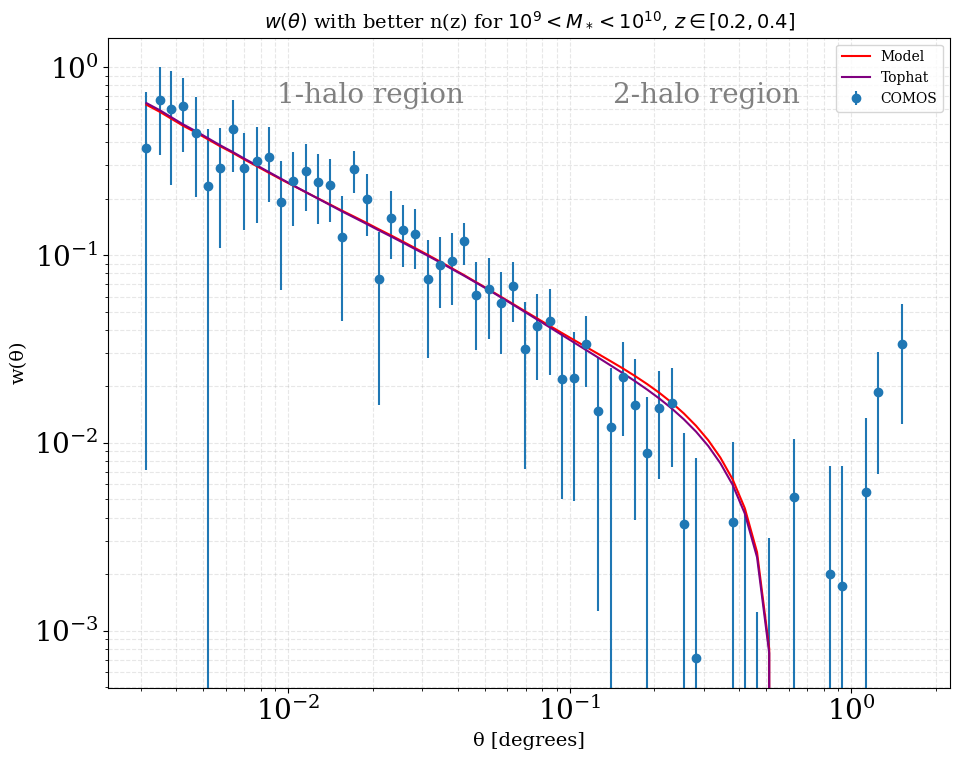

In [70]:
theta = results['theta']
w_obs = results['w_theta']
var_w_obs= results['var_w_theta_bootstrap']
w_err = np.sqrt(var_w_obs)


w_m = s.hod_model(logM_min *1e7, logM_1, alpha) 



plt.figure(figsize=(10, 8))

plt.errorbar(theta, w_obs, yerr= w_err, fmt='o', label= 'COMOS')
plt.plot(theta, w_model, label='Model', color='red')
plt.plot(theta, w_m,label='Tophat', color='purple')



plt.xscale('log')
plt.yscale('log')
#plt.ylim([1e-4,10.])

plt.xlabel('θ [degrees]', fontsize=14)
plt.ylabel('w(θ)', fontsize=14)
plt.title(f'$w(\\theta)$ with better n(z) for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [{z_min},{z_max}]$', fontsize=14)

plt.legend(fontsize=10, framealpha=0.8)
plt.grid(True, which="both", ls="--", alpha=0.3)

# Add annotations
plt.text(0.2, 0.9, "1-halo region", transform=plt.gca().transAxes, color='gray')
plt.text(0.6, 0.9, "2-halo region", transform=plt.gca().transAxes, color='gray')


plt.tight_layout()
plt.show()